<a href="https://colab.research.google.com/github/Ramubala/Autoencoders/blob/main/Auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import torch
from torch import nn
import torchvision
from torchvision import transforms


!python -m pip install pytorch-lightning -q
import pytorch_lightning

In [86]:
#!rm -r '/content/data'

In [87]:
# lets use LFW dataset for our analysis
transform = transforms.Compose([
    transforms.ToTensor()
]
    #transforms.CenterCrop(10),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

training_data = torchvision.datasets.LFWPeople('/content/train_data',split='train',download=True, transform=transform)
test_data = torchvision.datasets.LFWPeople('/content/test_data',split='test',download=True)

Files already downloaded and verified
Files already downloaded and verified


In [88]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [89]:
training_data[0][0].shape#, train_dataset[0][1]

torch.Size([3, 250, 250])

torch.Size([64, 3, 250, 250]) torch.Size([64])
torch.Size([3, 2018, 2018])


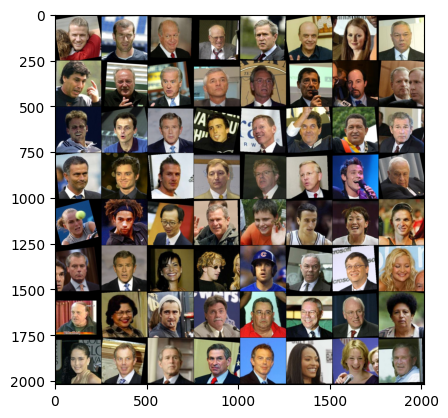

In [90]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for (idx, batch) in enumerate(train_dataloader):
    print(batch[0].shape, batch[1].shape)
    grid=make_grid(batch[0], 8)
    print(grid.shape)
    plt.imshow(grid.permute(1, 2, 0))
    break

In [95]:
from torchsummary import summary
from pytorch_lightning import LightningModule

class Encoder(LightningModule):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 32, 5, 2, 5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(32, 64, 4, 2, 4),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 128, 4, 2, 4),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        nn.Linear(3200, 1024),
        nn.ReLU(),
        nn.Linear(1024, 128)
    )

  def forward(self,x):
    return self.model(x)


enc=Encoder()
print(summary(enc,(3,250,250)))

# for (idx, batch) in enumerate(train_dataloader):
#     print(batch[0].shape, batch[1].shape)
#     print(enc(batch[0]).shape)
#     break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 35, 35]          32,832
              ReLU-5           [-1, 64, 35, 35]               0
         MaxPool2d-6           [-1, 64, 17, 17]               0
            Conv2d-7          [-1, 128, 11, 11]         131,200
              ReLU-8          [-1, 128, 11, 11]               0
         MaxPool2d-9            [-1, 128, 5, 5]               0
          Flatten-10                 [-1, 3200]               0
           Linear-11                 [-1, 1024]       3,277,824
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 128]         131,200
Total params: 3,575,488
Trainable param

In [96]:
class Decoder(LightningModule):
  def __init__(self):

    super().__init__()
    
    self.model = nn.Sequential(
        nn.Linear(128, 1024),
        nn.ReLU(),
        nn.Linear(1024, 3200),
        nn.Unflatten(1,(128,5,5)),
        nn.Upsample((11,11)),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 3, 2, 3),    
        nn.Upsample((35,35)),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, 2, 4),    
        nn.Upsample((128,128)),
        nn.ReLU(),
        nn.ConvTranspose2d(32,3,4,2,4),

    )

  def forward(self,x):
    return self.model(x)


dec=Decoder()
print(summary(dec,(128,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         132,096
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 3200]       3,280,000
         Unflatten-4            [-1, 128, 5, 5]               0
          Upsample-5          [-1, 128, 11, 11]               0
              ReLU-6          [-1, 128, 11, 11]               0
   ConvTranspose2d-7           [-1, 64, 17, 17]          73,792
          Upsample-8           [-1, 64, 35, 35]               0
              ReLU-9           [-1, 64, 35, 35]               0
  ConvTranspose2d-10           [-1, 32, 64, 64]          32,800
         Upsample-11         [-1, 32, 128, 128]               0
             ReLU-12         [-1, 32, 128, 128]               0
  ConvTranspose2d-13          [-1, 3, 250, 250]           1,539
Total params: 3,520,227
Trainable param

In [97]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F

class AutoEncoder(LightningModule):
  def __init__(self):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()

  def forward(self,x):
    bottle_neck = self.enc(x)
    reconstructed = self.decoder(bottle_neck)
    return reconstructed

  def training_step(self, batch, batch_idx):
    x, _ = batch
    preds = self.forward(x)
    loss = F.mse_loss(preds, x)
    return loss

  def validation_step(self, batch, batch_idx):
    self._shared_eval(batch, batch_idx, "val")

  def test_step(self, batch, batch_idx):
    self._shared_eval(batch, batch_idx, "test")

  def _shared_eval(self, batch, batch_idx, prefix):
    x, _ = batch
    preds = self.forward(x)
    loss = F.mse_loss(preds, x)
    self.log(f"{prefix}_loss", loss)

  def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(opt, T_max=10)
    return [opt], [scheduler]

In [98]:
autoenc_model = AutoEncoder()

In [99]:
from pytorch_lightning import Trainer

trainer = Trainer()
trainer.fit(autoenc_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | enc  | Encoder | 3.6 M 
1 | dec  | Decoder | 3.5 M 
---------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.383    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


TypeError: ignored